In [35]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import KFold
from lightfm.data import Dataset
from lightfm import LightFM
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('./pkl/df.pickle')
df_items = pd.read_pickle('./pkl/df_items.pickle')
df_users = pd.read_pickle('./pkl/df_users.pickle')

In [3]:
item_feature = np.load('./pkl/item_feature.pickle.npy', allow_pickle=True)

In [4]:
user_feature = np.load('./pkl/user_feature.pickle.npy', allow_pickle=True)

In [5]:
cv = KFold(n_splits = 5, shuffle=False)

In [6]:
folds = list(cv.split(df))

In [7]:
dataset = Dataset()
dataset.fit(df['user_id'].unique(), df['item_id'].unique())
dataset.fit_partial(user_features=user_feature)
dataset.fit_partial(item_features=item_feature)

In [8]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('users_mapping len - ', len(lightfm_mapping['users_mapping']))
print('user_features_mapping len - ', len(lightfm_mapping['user_features_mapping']))
print('items_mapping len - ', len(lightfm_mapping['items_mapping']))
print('Users item_features_mapping len - ', len(lightfm_mapping['item_features_mapping']))

users_mapping len -  31526
user_features_mapping len -  31534
items_mapping len -  14717
Users item_features_mapping len -  17497


In [9]:
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [10]:
def df_to_tuple_iterator(df):
    return zip(*df.values.T)

def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [11]:
train_idx, test_idx = folds[0]

train = df.loc[train_idx]
test = df.loc[test_idx]

In [12]:
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(train[['user_id', 'item_id']]))

In [13]:
known_users_filter = df_users['user_id'].isin(df['user_id'].unique())
train_user_features = dataset.build_user_features(
    df_to_tuple_list_iterator(
        df_users.loc[known_users_filter, ['user_id', 'features']]
    )
)

In [14]:
known_items_filter = df_items['id'].isin(df['item_id'].unique())
train_items_features = dataset.build_item_features(
    df_to_tuple_list_iterator(
        df_items.loc[known_items_filter, ['id', 'features']]
    )
)

In [15]:
lfm_model = LightFM(no_components=64, learning_rate=0.05, loss='warp', max_sampled=5, random_state=23)

In [16]:
num_epochs = 15
for _ in tqdm(range(num_epochs), total=num_epochs):
    lfm_model.fit_partial(
        train_mat, 
        user_features=train_user_features,
        item_features=train_items_features,
        num_threads=4
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [02:53<00:00, 11.54s/it]


In [17]:
recs = pd.DataFrame({
    'user_id': test['user_id'].unique()
})

In [18]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, user_features, item_features, N, user_mapping, item_inv_mapping, num_threads=4):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, item_features=item_features, num_threads=num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [19]:
known_items = train.groupby('user_id')['item_id'].apply(list).to_dict()
len(known_items)

25957

In [23]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

14717

In [25]:
top_N = 10

In [26]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=train_user_features, 
    item_features=train_items_features, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=4
)

In [27]:
%%time
recs['item_id'] = recs['user_id'].map(mapper)

CPU times: user 1min 55s, sys: 363 ms, total: 1min 55s
Wall time: 30.5 s


In [28]:
recs = recs.explode('item_id')
recs['rank'] = recs.groupby('user_id').cumcount() + 1

In [29]:
def compute_metrics(df_true, df_pred, top_N):
    result = {}
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', 'rank'])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')['rank'].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs['rank']).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']
    
    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs['rank'] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)

In [30]:
metrics = compute_metrics(test, recs, top_N)

Precision@1     0.618201
Recall@1        0.008341
Precision@2     0.569198
Recall@2        0.015535
Precision@3     0.539400
Recall@3        0.020040
Precision@4     0.525220
Recall@4        0.026048
Precision@5     0.522599
Recall@5        0.032144
Precision@6     0.516724
Recall@6        0.036657
Precision@7     0.506629
Recall@7        0.040107
Precision@8     0.498407
Recall@8        0.043853
Precision@9     0.493747
Recall@9        0.047549
Precision@10    0.489894
Recall@10       0.052057
MAP@10          0.032310
MRR             0.686656
dtype: float64

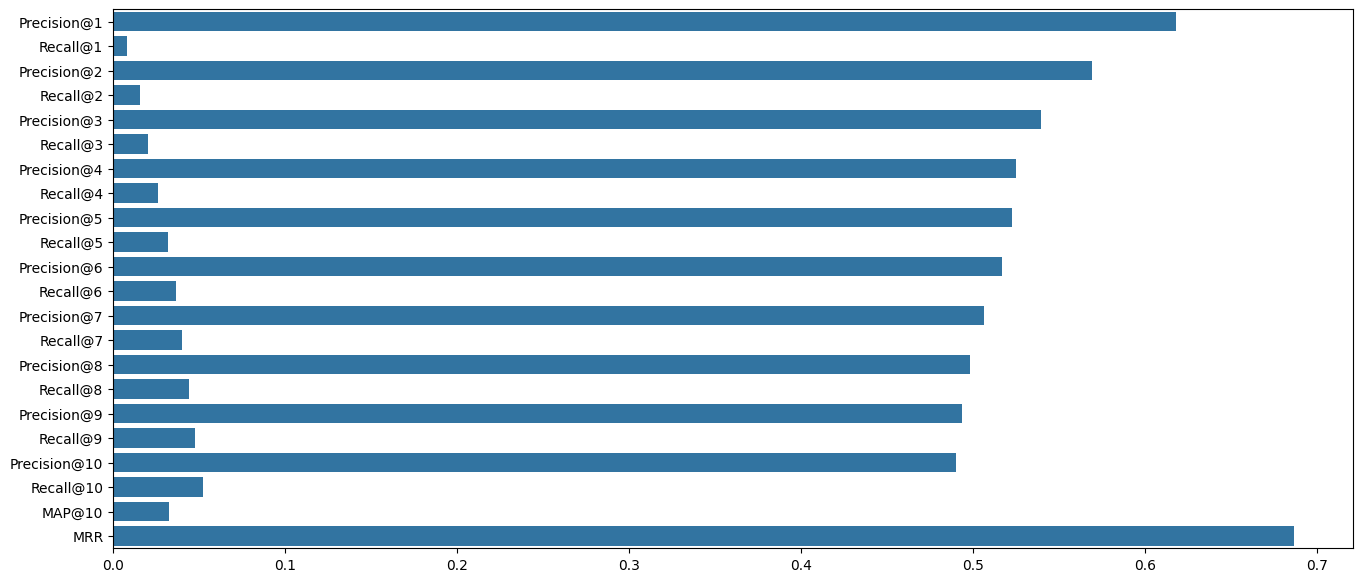

In [45]:
fig = plt.figure(figsize=(16,7))
sns.barplot(metrics, orient="y")
plt.show();